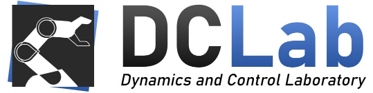

## Build ResNet from Scratch With Python !

**Dogs VS Cats Classification With Resnet**

The Dogs & Cats is a foundational problem for a basic CNN(convolutional neural network) model which involves classifying images as a dog or a cat.The dataset can be used for learning how to develop,evaluate and use convolutional deep learning neural networks for classification of images. 

The dataset can be downloaded for free from the Kaggle website.
Download the dataset by visiting the Dogs vs. Cats Data page and click the “Download All” button.
Dataset Link : https://www.kaggle.com/c/dogs-vs-cats
This will download the 850-megabyte file “dogs-vs-cats.zip” to your workstation.
Unzip the file and you will see train.zip, train1.zip and a .csv file. Unzip the train.zip file, as we will be focusing only on this dataset.
You will now have a folder called ‘train/‘ that contains 25,000 .jpg files of dogs and cats. The photos are labeled by their filename, with the word “dog” or “cat“. 

**Import Library**

In [ ]:
import os
import cv2
import random
import shutil
import numpy as np 
import pandas as pd 
from keras.models import load_model
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from keras.models import Sequential,Model
from keras.layers import Conv2D,Flatten,MaxPooling2D,Dense,GlobalAveragePooling2D,Dropout,BatchNormalization
from sklearn.model_selection import train_test_split

**Prepare Training Data**

Now our dataset contains only images of dogs and cats with filenames like 'dog.1.png' or 'cat.255.png'. Here we have prepared our label dataset by splitting image name with '.'  eg  if image name is 'dog.1.png' we split it by '.' as delimiter and extract first part of image name ('dog' here ) and if it is dog the we append 1 in list else we append 0 in list.So now basically we have our dataset comprising of images and labels corresponding to each images 
* if label = 1 , image corresponds to dog and 
* label = 0 if image corresponds to cat.

We have stored filenames and labels using pandas dataframe.

In [ ]:
Y = []
path = "./train"
filenames = os.listdir(path)
for img in os.listdir(path):
    val = img.split(".")[0]
    if val == "dog":
        Y.append('1')
    else:
        Y.append('0')

df = pd.DataFrame({
    'filename' : filenames,
    'category' : Y
})

Here we see few initial values of our dataframe using df.head()

In [ ]:
df.head()

Here we see few last values of our dataframe using df.tail()

In [ ]:
df.tail()

**Plot Random Dataset Image**

Looking at a few random images in the directory, we can see that the images are coloured and have different shapes and sizes. For example, let’s load and plot some random images of dataset in a single figure. Running below code creates a figure showing some random images from the dataset.We can see that some images are landscape format, some are portrait format, and some are square.

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(4, 3, i+1)
    sample = random.choice(filenames)
    filename = path+'/'+sample
    image = imread(filename)
    plt.imshow(image)
plt.tight_layout()
plt.show()

**Train Test Split**

Here we are splitting our dataset into two parts. We are separating 20% of our dataset images for validation purpose and keeping rest for training purpose.This is done because we want to validate our trained model on a new set of images and not on the same set of images on which the model is trained. Therefore we want a different set of images apart from our training set upon which we can test our model and see the performance of the trained model on new unseen images.

In [ ]:
train_df,test_df = train_test_split(df,test_size=0.2,random_state = 42)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
print(test_df)

**Training Dataframe shape**

To see our training dataframe shape we are using train_df.shape

In [ ]:
train_df.shape

**Validation Dataframe shape**

To see our training dataframe shape we are using val_df.shape

In [ ]:
test_df.shape

Here we are defining constants to be used in our model code. So as to make our code modular we define all constants in a separate cell.


In [ ]:
train_size = train_df.shape[0]
test_size = test_df.shape[0]
img_hieght = 64
img_width = 64
img_channels = 3
batch_size = 32

**Training Generator**

Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset.Training deep learning neural network models on more data can result in more skillful models, and the augmentation techniques can create variations of the images that can improve the ability of the fit models to generalize what they have learned to new images. Data augmentation can also act as a regularization technique, adding noise to the training data, and encouraging the model to learn the same features, invariant to their position in the input. Small changes to the input photos of dogs and cats might be useful for this problem, such as small shifts and horizontal flips. These augmentations can be specified as arguments to the ImageDataGenerator used for the training dataset. The augmentations should not be used for the validation dataset, as we wish to evaluate the performance of the model on the unmodified photographs.                    
We can use the flow_from_dataframe() function on the data generator and create one iterator for each of the train and validation set. With the help of flow_from_dataframe method you can directly pass the Pandas DataFrame which has the mapping between filenames of the images and their labels..We must specify that the problem is a binary classification problem via the “class_mode” argument, and to load the images with the size of 128×128×3 pixels via the “target_size” argument. We will fix the batch size at 32.

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    horizontal_flip = True,
    zoom_range = 0.2,
    shear_range = 0.1,
    fill_mode = 'reflect',
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "./train",
    x_col = 'filename',
    y_col = 'category',
    target_size = (img_hieght,img_width),
    batch_size = batch_size,
    class_mode = 'binary'
)

**Test Generator**

We will not apply any data augmentation technique like horizontal flip, zoom etc on validation set because we are not going to use this for training purpose.

In [ ]:
test_datagen = ImageDataGenerator(
    rescale = 1./255,
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    "./train",
    x_col = 'filename',
    y_col = 'category',
    target_size = (img_hieght,img_width),
    batch_size = batch_size,
    class_mode = 'binary'
)

## Building Your First ResNet Model (50 layers)

In this section, we can develop a convolutional neural network model for the dogs vs. cats dataset.

*Layers needed by Resnet*

* Conv2D :- Basic Convolutional layer which is used to extract features from our image.
* MaxPooling :- CNN has a concept of max pooling. After every convoulution we get some values in a kernel. However in max pooling we select max kernel value.It helps us to reduce unnecessary noise from our data and keep only useful values for training.
* BatchNormalization:- This layer helps for normalization of our input values which helps in fast learning of our model.

* Dense:- Dense layer is needed by every neural network to finally output the result however every once in while using a Dense layer helps in making model learn.
*  Flatten:- Conv2D layer returns doesn't return a flatten data hence we need Flatten layer before feeding it into final Dense layer.

You'll need to use this function: 
- Average pooling [see reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D)

Here are some other functions we used in the code below:
- Conv2D: [See reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
- BatchNorm: [See reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)
- Max pooling: [See reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)
- Fully connected layer: [See reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)
- Addition: [See reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add)

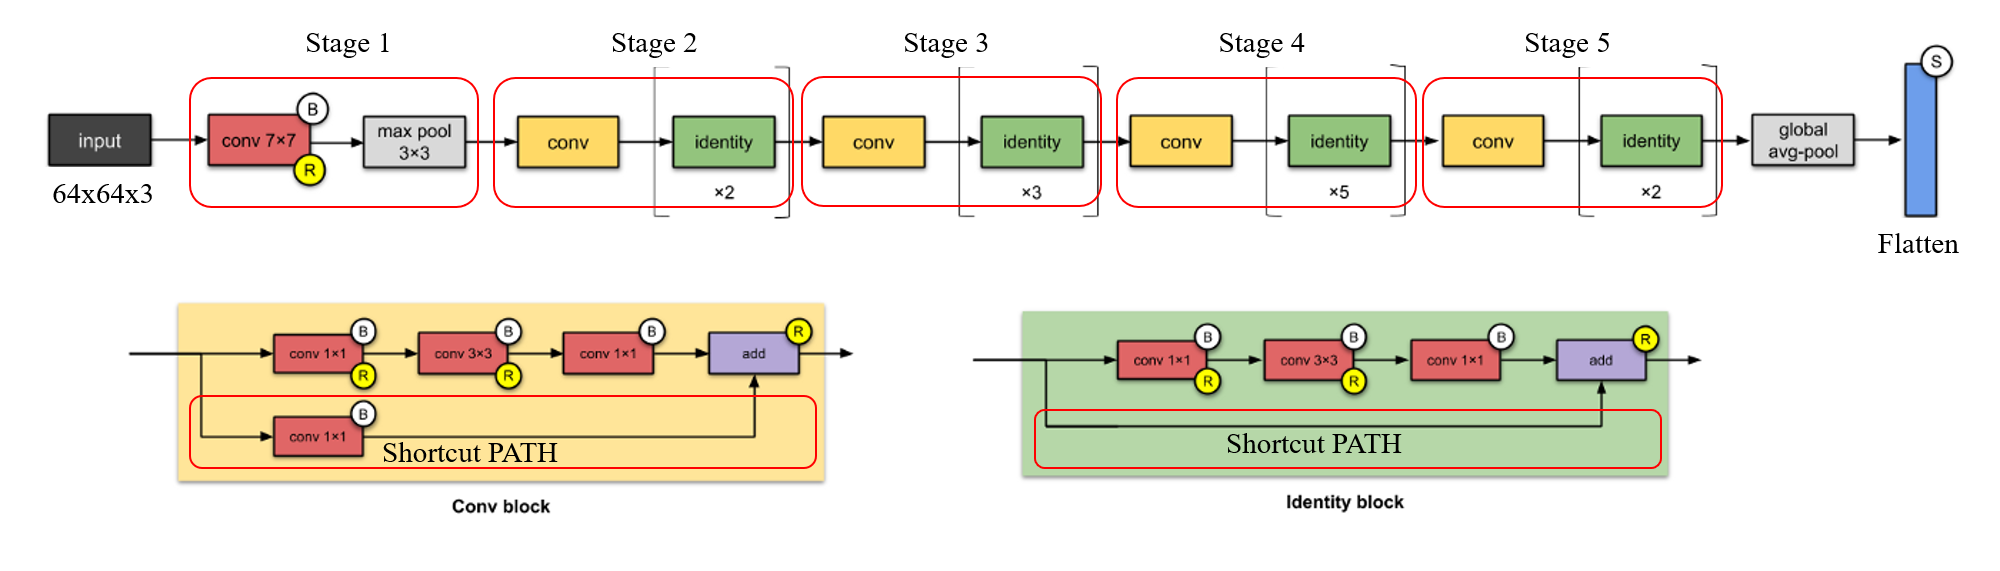

This image is just an example of cnn model, it not describes our exact model

**Important part**

The details of this ResNet-50 model are:

    Stage 1:
        The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2).
        BatchNorm is applied.
        MaxPooling uses a (3,3) window and a (2,2) stride.
    Stage 2:
        The convolutional block uses three sets of filters of size [64,64,256,256]
             1. 64 for conv 1x1 and (2,2) stride in First component of main path 
             2. 64 for conv 3x3 in Second component of main path
             3. 256 for conv 1x1 in Third component of main path 
             4. 256 for conv 1x1 and (2,2) stride in SHORTCUT PATH.
        The 2 identity blocks use three sets of filters of size [64,64,256].
    Stage 3:
        The convolutional block uses three sets of filters of size [128,128,512,512].
             1. 128 for conv 1x1 and (2,2) stride in First component of main path 
             2. 128 for conv 3x3 in Second component of main path
             3. 512 for conv 1x1 in Third component of main path 
             4. 512 for conv 1x1 and (2,2) stride in SHORTCUT PATH.
        The 3 identity blocks use three sets of filters of size [128,128,512].
    Stage 4:
        The convolutional block uses three sets of filters of size [256, 256, 1024,1024].
             1. 256 for conv 1x1 and (2,2) stride in First component of main path 
             2. 256 for conv 3x3 in Second component of main path
             3. 1024 for conv 1x1 in Third component of main path 
             4. 1024 for conv 1x1 and (2,2) stride in SHORTCUT PATH.
        The 5 identity blocks use three sets of filters of size [256, 256, 1024].
    Stage 5:
        The convolutional block uses three sets of filters of size [512, 512, 2048,2048].
             1. 512 for conv 1x1 and (2,2) stride in First component of main path 
             2. 512 for conv 3x3 in Second component of main path
             3. 2048 for conv 1x1 in Third component of main path 
             4. 2048 for conv 1x1 and (2,2) stride in SHORTCUT PATH.  
        The 2 identity blocks use three sets of filters of size [512, 512, 2048].
    The 2D Average Pooling uses a pool_size=(2, 2).
    The 'flatten' layer doesn't have any hyperparameters.
    The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.

**Noted From stage 2 to stage 5 use (2,2) stride for 2D Convolution of First component of main path and SHORTCUT PATH.** 

## Exercise - ResNet50
### Let’s Build ResNet from scratch:
#####  It's showtime, guys!!!!

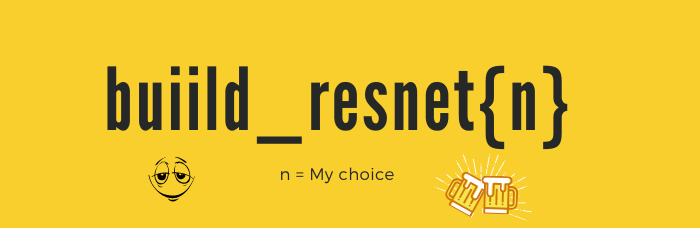

In [ ]:
input = layers.Input(shape=((img_hieght,img_width,img_channels)),name ='Input_Image')

x = layers.ZeroPadding2D((3, 3))(input)
# Stage 1
x = layers.Conv2D(64, (7, 7), strides = (2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

# Stage 2

## Convolotion Block
# Save the input value
x_shortcut = x

# First component of main path 
x = layers.Conv2D(filters = 64, kernel_size = 1, strides = (1, 1), padding='valid')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
    
## Second component of main path 
x = layers.Conv2D(filters = 64, kernel_size = 3,strides = (1, 1),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

## Third component of main path 
x = layers.Conv2D(filters = 256, kernel_size = 1, strides = (1, 1), padding='valid')(x)
x = layers.BatchNormalization()(x)
    
##### SHORTCUT PATH ##### 
x_shortcut = layers.Conv2D(filters = 256 , kernel_size = 1, strides = (1,1), padding='valid')(x_shortcut)
x_shortcut = layers.BatchNormalization()(x_shortcut)
    
# Final step: Add shortcut value to main path (Use this order [x, x_shortcut]), and pass it through a RELU activation
x = layers.Add()([x, x_shortcut])
x = layers.Activation('relu')(x)

### START CODE HERE

## identity_block 1
# Save the input value.

# First component of main path 

## Second component of main path

## Third component of main path 

## identity_block 2
# Save the input value.

# First component of main path 

## Second component of main path

## Third component of main path 

# Final step: Add shortcut value to main path and pass it through a RELU activation

# Stage 3


# Stage 4


# Stage 5


## AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"

output = layers.Dense(1,activation='sigmoid')(x)
### END CODE HERE
model = keras.Model(inputs = input, outputs =output)

model.summary() gives the description of the architecture of our model.

In [ ]:
model.summary()

Finally we will compile the model .There are 3 things to mention here : Optimizer,Loss, Metrics
* Optimizer :- To minimize cost function we use different methods For ex :- like gradient descent, stochastic gradient descent. So these are call optimizers. We are using a default one here which is adam.
* Loss :- To make our model better we either minimize loss or maximize accuracy. Neural Networks always minimize loss. To measure it we can use different formulas like 'categorical_crossentropy' or 'binary_crossentropy'. Here I have used binary_crossentropy.
* Metrics :- This is to denote the measure of your model. Can be accuracy or some other metric.

In [ ]:
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

**Fit Model**

We are now going to train our compiled model using the train iterator (train_generator) and use the val iterator (val_generator) as a validation dataset during training.The number of steps for the train and validation iterators must be specified. This is the number of batches that will comprise one epoch. This can be specified via the length of each iterator, and will be the total number of images in the train and validation directories divided by the batch size (32).The model will be fit for 10 epochs.

In [ ]:
model.fit(train_generator, epochs = 10, steps_per_epoch = train_size//32)


**Saving the Model**

Once fit, we can save the final model to an .h5 file by calling the save() function on the model and pass in the chosen filename.

In [ ]:
model.save("model_resnet.h5")

Below code can be used to load model weights from save model.h5 file. So that we don't have to go through full trainnig process again.

In [ ]:
# model = load_model("/kaggle/input/mode-file/model.h5")

**Test Accuracy**

Now we will calculate our model's accuracy on validation set with use of keras  *.evaluate_generator()* function. We have used score[1]*100 because output of evaluate() is a list of which second element represents accuracy of model on passed dataset.

In [ ]:
score = model.evaluate(test_generator)
print(score[1]*100)

**Training Accuracy**

Here we are going to calculate model's accuracy on training set itself.

In [ ]:
score_train = model.evaluate(train_generator)
print(score_train [1]*100)

### Woo hoo!  Congratulations
on finishing this assignment! You've now implemented a state-of-the-art image classification system! 

ResNet50 is a powerful model for image classification when it's trained for an adequate number of iterations. Hopefully, from this point, you can use what you've learned and apply it to your own classification problem to perform state-of-the-art accuracy.

### Test on Your Own Image

Here we will see the prediction of our model on a new image with use of model.predict function

In [ ]:
path = "2.jpg"
img = cv2.imread(path)
plt.imshow(img)
img = cv2.resize(img,(128,128))
img = np.reshape(img,[1,128,128,3])
img = np.divide(img,255)
result = model.predict(img)
if result[0] >= 0.5:
    print("According to our model's prediction below image is of a Dog")
else:
    print("According to our model's prediction below image is of a Cat")


## Bibliography

This notebook presents the ResNet algorithm from He et al. (2015). The implementation here also took significant inspiration and follows the structure given in the GitHub repository of Francois Chollet: 

- Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun - [Deep Residual Learning for Image Recognition (2015)](https://arxiv.org/abs/1512.03385)
- Francois Chollet's GitHub repository: https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py

Author : Moeurn Dear